# Hydroglaciology

In [2]:
import csv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy
import math
import datetime
import time
import obspy

In [3]:
direct = 'D:\MEMOIRE\HYDRO'
stt_gauging = '\V550\Vdv_data_20221116122909'
stt_temp = '\V299\Vdv_data_20221120143940'

In [4]:
gauging_time = []
gauging_velos = []

with open(direct+stt_gauging+'.csv') as file :
    readcsv = csv.reader(file, delimiter=';')
    line = 0
    for row in readcsv :
        if line > 4 :
            gauging_date = datetime.datetime.strptime(str(row[0]), '%Y-%m-%d %H:%M:%S')
            gauging_time.append(gauging_date)
            gauging_velos.append(float(row[3].replace(',','.')))
            
        line += 1

temp_time = []
temp = []

with open(direct+stt_temp+'.csv') as file :
    readcsv = csv.reader(file, delimiter=';')
    line = 0
    for row in readcsv :
        if line > 4 :
            temp_date = datetime.datetime.strptime(str(row[0]), '%Y-%m-%d %H:%M:%S')
            temp_time.append(temp_date)
            temp.append(float(row[1].replace(',','.')))
            
        line += 1

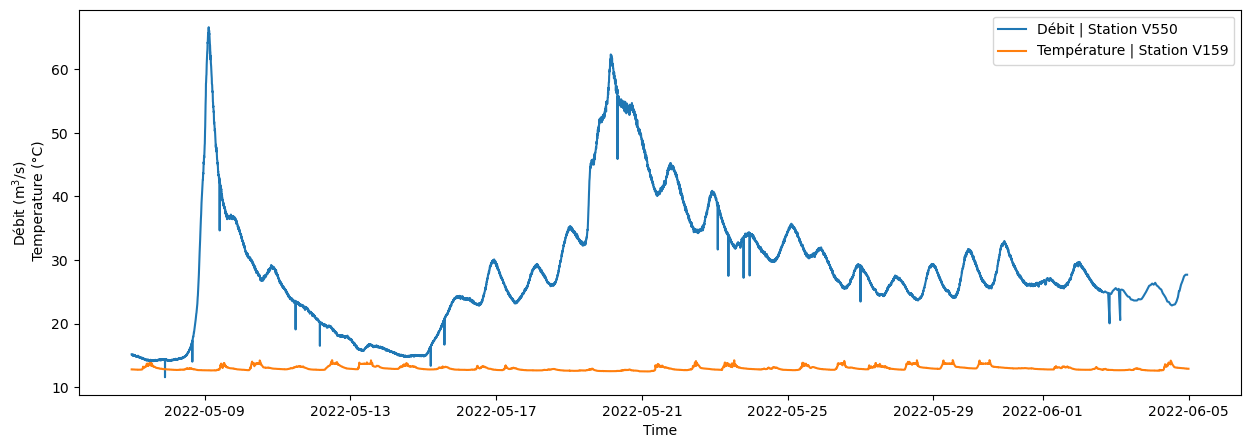

In [5]:
fig = plt.figure(figsize=(15, 5))
plt.plot(gauging_time, gauging_velos, label = 'Débit | Station V550')
plt.plot(temp_time, temp, label = 'Température | Station V159')
plt.xlabel('Time')
plt.ylabel('Débit (m$^3$/s) \n Temperature (°C)')
plt.legend()
plt.show()

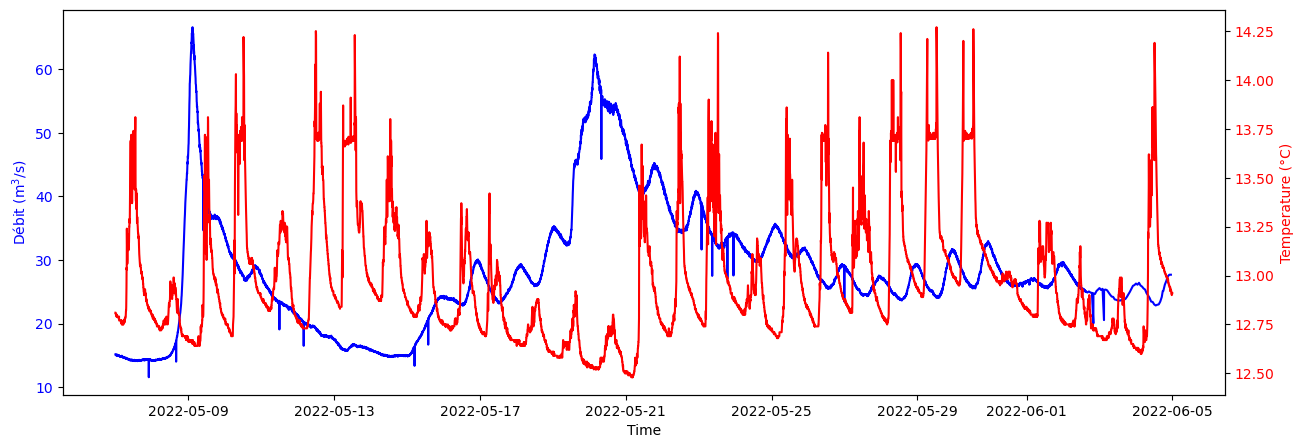

In [6]:
fig, ax1 = plt.subplots(figsize=(15,5)) 
  
ax1.set_xlabel('Time') 
ax1.set_ylabel('Débit (m$^3$/s)', color = 'blue') 
ax1.plot(gauging_time, gauging_velos, label = 'Débit | Station V550', c='blue')
ax1.tick_params(axis ='y', labelcolor = 'blue') 
  
# Adding Twin Axes

ax2 = ax1.twinx() 
  
ax2.set_ylabel('Temperature (°C)', color = 'red') 
ax2.plot(temp_time, temp, label = 'Température | Station V159', c='red')
ax2.tick_params(axis ='y', labelcolor = 'red') 
 
# Show plot

plt.show()

## Determining the frequency of the signal
Crédit :
https://stackoverflow.com/questions/27673496/python-numpy-fft-or-rfft-to-find-period-of-a-wave-instead-of-its-frequiency

In [7]:
#sample_rate = 180
temp = np.array(temp)
amp_temp =np.abs(np.fft.rfft(temp, n=temp.size))
freq_temp = np.fft.rfftfreq(temp.size, d=1/288)
amp_temp[0] = 0
idx = amp_temp.argmax()
print(freq_temp[idx])

1.0


In [8]:
#sample_rate = 180
gauging_velos = np.array(gauging_velos)
amp_gauging_velos =np.abs(np.fft.rfft(gauging_velos, n=gauging_velos.size))
freq_gauging_velos = np.fft.rfftfreq(gauging_velos.size, d=1/288)
amp_gauging_velos[0] = 0
idx = amp_gauging_velos.argmax()
print(freq_gauging_velos[idx])

0.0371517027864


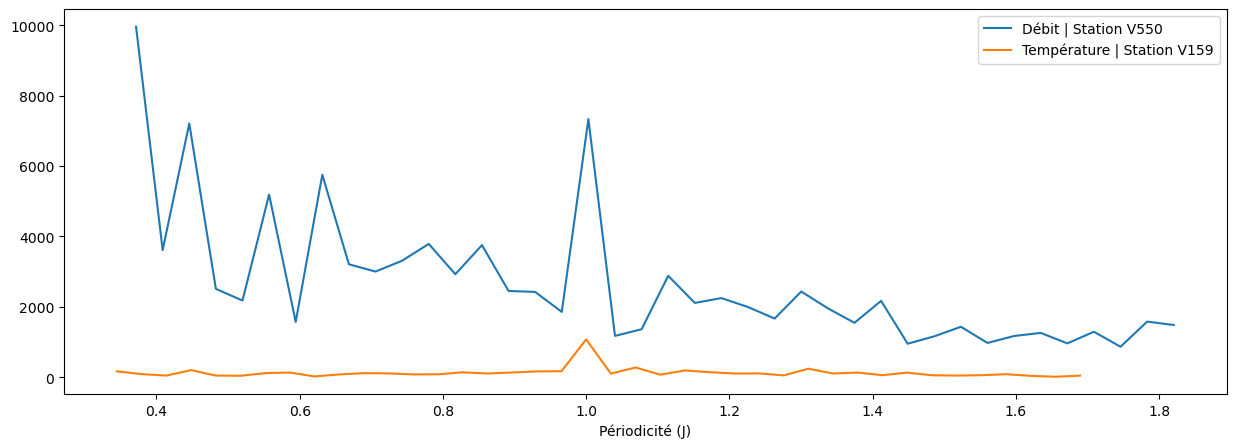

In [9]:
fig = plt.figure(figsize=(15, 5))
plt.plot(freq_gauging_velos[10:50], amp_gauging_velos[10:50], label="Débit | Station V550")
plt.plot(freq_temp[10:50], amp_temp[10:50] , label="Température | Station V159")
plt.xlabel('Périodicité (J)')
plt.legend()
plt.show()


In [10]:
n=1
max_temp = []
max_velos = []
for i in range(len(temp_time)):
    #print(i)
    if temp_time[0] == temp_time[i] - datetime.timedelta(hours=n*24) :
        idx = np.argmax(temp[i-288:i]) + (i-288)
        max_temp.append(temp_time[idx])
        #print(i-456)
        n+= 1
        
n=1        
for i in range(len(gauging_time)):
    #print(i)
    if gauging_time[0] == gauging_time[i] - datetime.timedelta(hours=n*24) :
        idx = np.argmax(gauging_velos[i-289:i]) + (i-289)
        max_velos.append(gauging_time[idx])
        n+= 1
    
delta_time = np.subtract(max_velos, max_temp)

for i in range(len(delta_time)) :
    delta_time[i] = delta_time[i]/datetime.timedelta(hours=1)
    

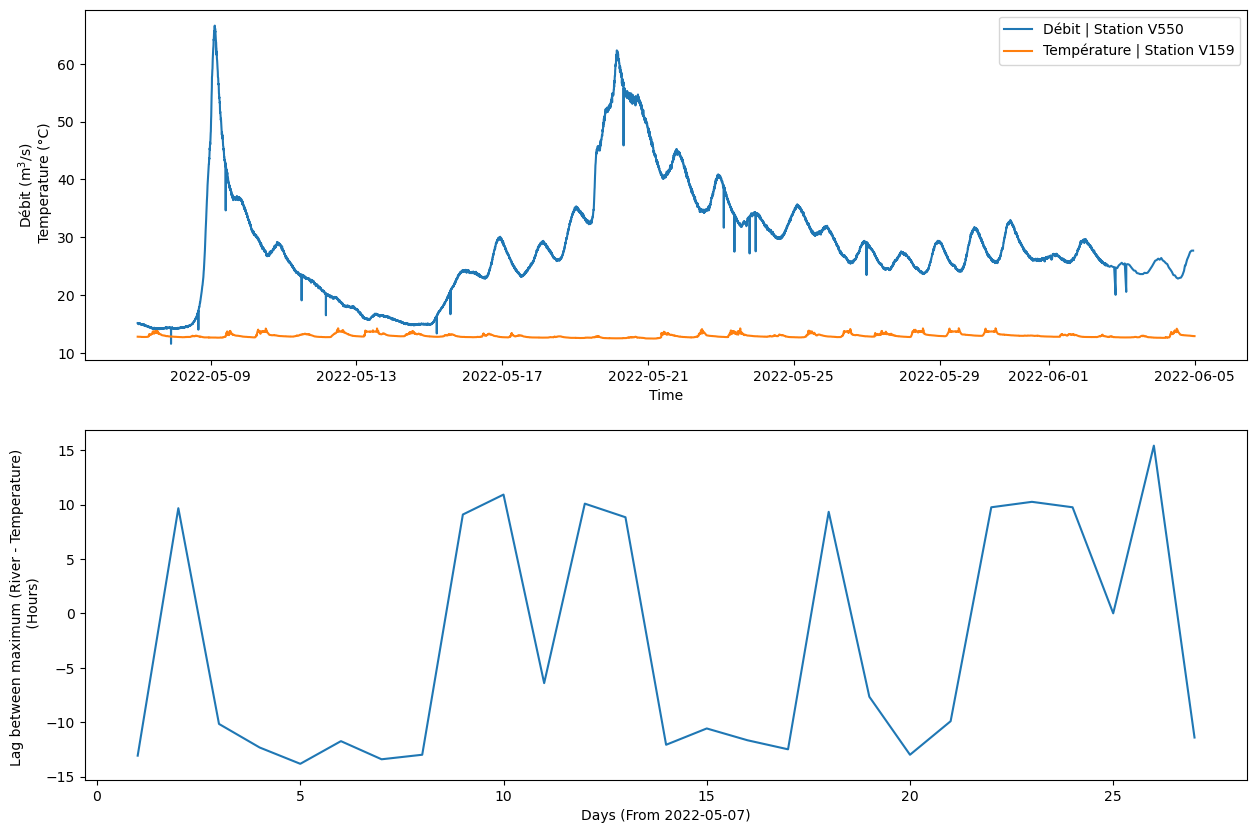

In [11]:
fig = plt.subplots(2, 1, figsize=(15, 10))
plt.subplot(2, 1, 1)


plt.plot(gauging_time, gauging_velos, label = 'Débit | Station V550')
plt.plot(temp_time, temp, label = 'Température | Station V159')
plt.xlabel('Time')
plt.ylabel('Débit (m$^3$/s) \n Temperature (°C)')
plt.legend()


plt.subplot(2, 1, 2)

day = list(range(1,28))
#plt.plot(day,max_temp.date())
#plt.plot(day,max_velos.time())
plt.plot(day, delta_time[:27])
plt.xlabel('Days (From 2022-05-07)')
plt.ylabel('Lag between maximum (River - Temperature) \n (Hours)')
plt.show()

In [12]:
file_precip = '\\PRECIP\\04176099999.csv'
starttime = '2022-05-07'
start = 0

precip_time = []
precip = []

with open(direct+file_precip) as file :
    readcsv = csv.reader(file, delimiter=',')
    line = 0
    for row in readcsv :
        if line > 0 :
            print(row[aa1])
        if line == 0 :
            aa1 = row.index('AA1')
            date = row.index('DATE')
        elif line > 0 and row[date][0:10] == starttime :
            print(row[date][0:10])
            start = 1
        elif start == 1 :
            precip_time.append(datetime.datetime.strptime(row[date],'%Y-%m-%dT%H:%M:%S'))
            precip.append(float(row[aa1][3:7]))
        line += 1


03,0000,9,1
03,9999,9,9
03,9999,9,9
03,0000,9,1
03,9999,9,9
03,9999,9,9
03,0000,9,1
03,9999,9,9
03,9999,9,9
03,0000,9,1
03,9999,9,9
03,9999,9,9
03,0000,9,1
03,9999,9,9
03,9999,9,9
03,0000,9,1
03,9999,9,9
03,9999,9,9
03,0000,9,1
03,0002,3,1
03,0002,3,1
03,0002,3,1
03,9999,9,9
03,9999,9,9
03,0000,9,1
03,9999,9,9
03,9999,9,9
03,0000,9,1
03,9999,9,9
03,9999,9,9
03,0000,9,1
03,9999,9,9
03,9999,9,9
03,0000,9,1
03,9999,9,9
03,9999,9,9
03,0000,9,1
03,9999,9,9
03,9999,9,9
03,0000,9,1
03,9999,9,9
03,9999,9,9
03,0000,9,1
03,9999,9,9
03,9999,9,9
03,0000,9,1
03,9999,9,9
03,9999,9,9
03,0000,9,1
03,9999,9,9
03,0000,9,1
03,9999,9,9
03,9999,9,9
03,0000,9,1
03,0001,3,1
03,0001,3,1
03,0001,3,1
03,9999,9,9
03,9999,9,9
03,0000,9,1
03,9999,9,9
03,9999,9,9
03,0000,9,1
03,9999,9,9
03,9999,9,9
03,0000,9,1
03,9999,9,9
03,9999,9,9
03,0000,9,1
03,9999,9,9
03,9999,9,9
03,0000,9,1
03,9999,9,9
03,9999,9,9
03,0000,9,1
03,9999,9,9
03,9999,9,9
03,0000,9,1
03,9999,9,9
03,9999,9,9
03,0000,9,1
03,9999,9,9
03,9999,9,9
03,0

ValueError: could not convert string to float: ''

## Confronting wave with water

In [13]:
root = "D:\\Nodes_ablation_zone\All_comp_DP_\\"
azimuth = ['N','E','Z']
Traces = []
for coump in azimuth :
    Traces.append(obspy.read(root+'453020739.16.2022.05.21.00.00.00.000.'+str(coump)+'.miniseed'))

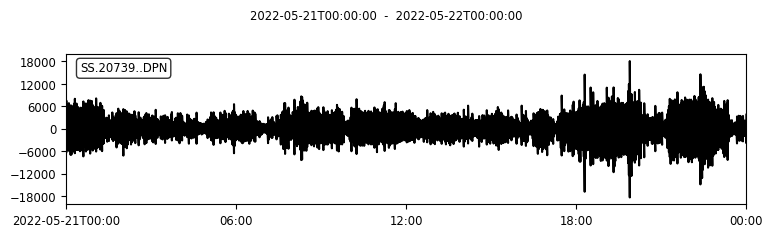

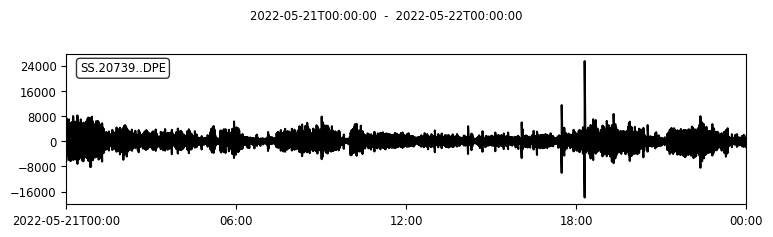

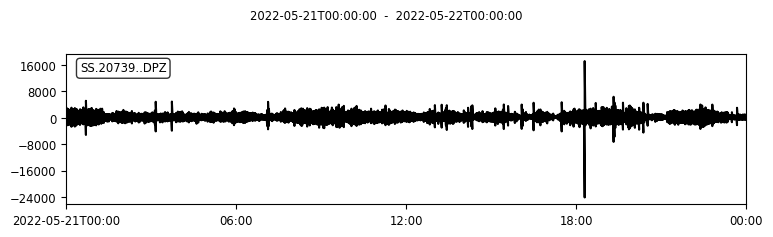

In [14]:
for trace in Traces :
    trace.plot()

In [19]:
root = "D:\\Nodes_ablation_zone\All_comp_DP_\\"

def amp_noise_mean_median(stt,window_size, startdate) :

    startdate = datetime.datetime.strptime(startdate, '%Y.%m.%d')
    startnumber = 3
    days = 31 - startnumber

    median = []
    mean = []

    for day in range(days) :
        start = time.process_time()
        date = startdate + datetime.timedelta(days = day)
        datetimeStr = date.strftime("%Y.%m.%d.%H.%M.%S.000")
        print(datetimeStr)
        trace = obspy.read(root+str(stt)+str(startnumber+day)+'.'+datetimeStr+'.Z.miniseed')
        if day == 0 :
            starttime = str(trace[0].stats.starttime)
            starttime = datetime.datetime.strptime(starttime, '%Y-%m-%dT%H:%M:%S.000000Z')
            noise_time = [starttime]

        window = 24*60/window_size

        trace = np.array(trace[0])

        trace = np.abs(trace)


        npts_p_min = int(len(trace)/(24*60))


        for i in range(int(window)) :
            t0 = i*npts_p_min
            t1 = npts_p_min + i*npts_p_min
            array = trace[t0:t1]
            mean.append(np.mean(array))
            median.append(np.median(array))
            if i > 0 and day == 0 :
                noise_time.append(noise_time[i-1]+datetime.timedelta(minutes=window_size))
            elif day > 0 :
                base = int(day*window)
                noise_time.append(noise_time[base+i-1]+datetime.timedelta(minutes=window_size))
        end = time.process_time() 
        print('Days '+str(day+startnumber)+' accomplished in '+str(end-start)+' seconds')
    return noise_time, mean, median

2022.05.08.00.00.00.000
Days 3 accomplished in 16.78125 seconds
2022.05.09.00.00.00.000
Days 4 accomplished in 12.84375 seconds
2022.05.10.00.00.00.000
Days 5 accomplished in 13.296875 seconds
2022.05.11.00.00.00.000
Days 6 accomplished in 12.34375 seconds
2022.05.12.00.00.00.000
Days 7 accomplished in 16.421875 seconds
2022.05.13.00.00.00.000
Days 8 accomplished in 16.625 seconds
2022.05.14.00.00.00.000
Days 9 accomplished in 16.171875 seconds
2022.05.15.00.00.00.000
Days 10 accomplished in 15.25 seconds
2022.05.16.00.00.00.000
Days 11 accomplished in 10.828125 seconds
2022.05.17.00.00.00.000
Days 12 accomplished in 17.140625 seconds
2022.05.18.00.00.00.000
Days 13 accomplished in 11.71875 seconds
2022.05.19.00.00.00.000
Days 14 accomplished in 17.234375 seconds
2022.05.20.00.00.00.000
Days 15 accomplished in 15.078125 seconds
2022.05.21.00.00.00.000
Days 16 accomplished in 14.015625 seconds
2022.05.22.00.00.00.000
Days 17 accomplished in 11.5 seconds
2022.05.23.00.00.00.000
Days 18 a

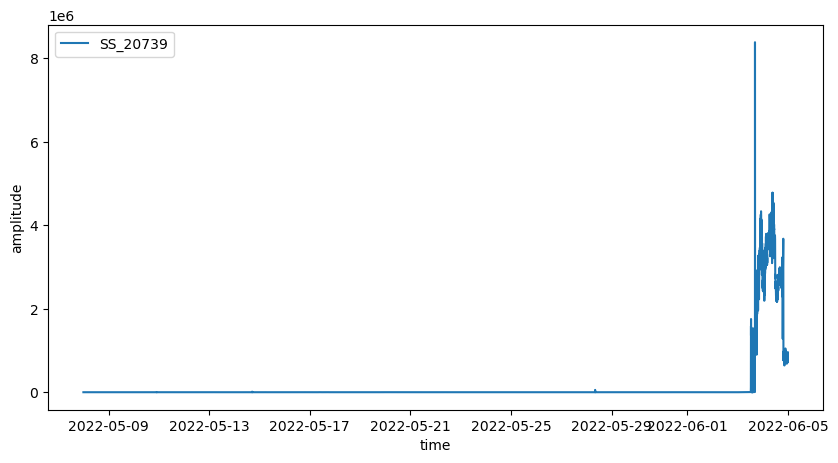

In [20]:
#noise_time773, mean773, median773 = amp_noise_mean_median('453020773.',1, '2022.05.08')
noise_time739, mean739, median739 = amp_noise_mean_median('453020739.',1, '2022.05.08')

fig = plt.figure(figsize=(10, 5))
#plt.plot(noise_time773,median773, label='SS_20773')
plt.plot(noise_time739,median739, label='SS_20739')
plt.xlabel('time')
plt.ylabel('amplitude')
plt.legend()
plt.show()

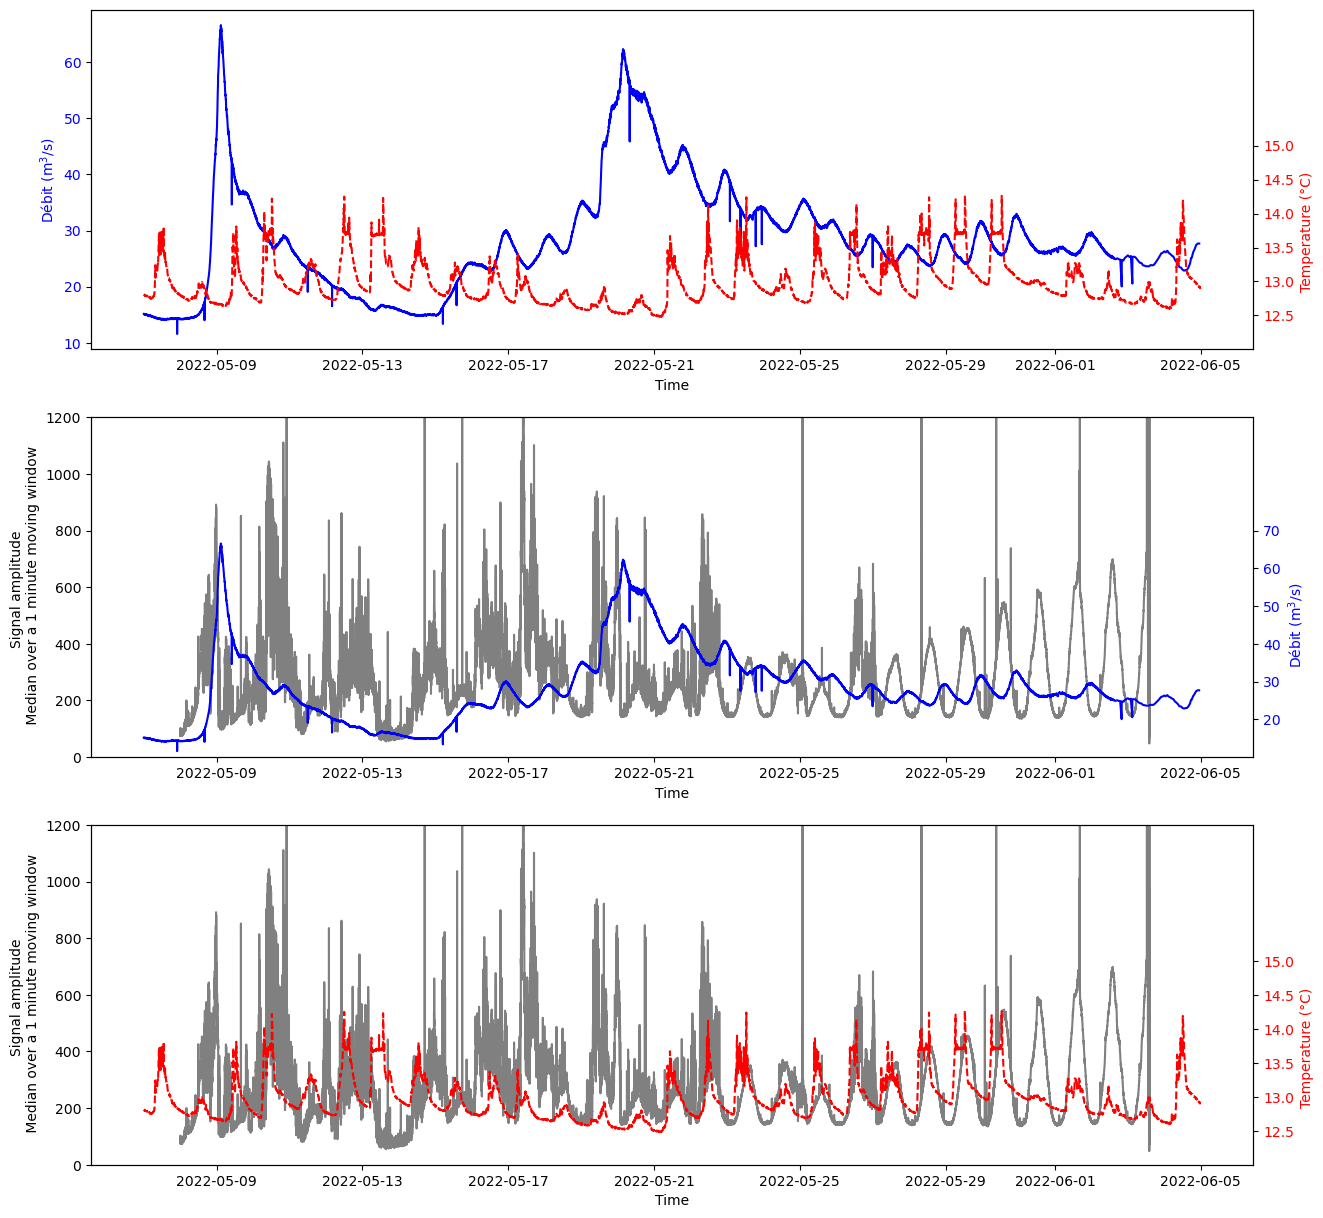

In [21]:
fig = plt.subplots(3, 1, figsize=(15, 15))

ax1 = plt.subplot(3, 1, 1)


ax1.set_xlabel('Time') 
ax1.set_ylabel('Débit (m$^3$/s)', color = 'blue') 
ax1.plot(gauging_time, gauging_velos, label = 'Débit | Station V550', c='blue')
ax1.tick_params(axis ='y', labelcolor = 'blue') 
  
# Adding Twin Axes

ax2 = ax1.twinx() 
    
ax2.set_ylabel('Temperature (°C)'+24*' ', color = 'red')
ax2.set_ylim((12,17))
ax2.set_yticks([12.5,13,13.5,14,14.5,15])
ax2.plot(temp_time, temp, label = 'Température | Station V299', c='red', linestyle='--')
ax2.tick_params(axis ='y', labelcolor = 'red') 

ax3 = plt.subplot(3, 1, 2)

ax3.set_xlabel('Time') 
ax3.set_ylabel('Signal amplitude \n Median over a 1 minute moving window') 
ax3.set_ylim((0,1200))
ax3.plot(noise_time739,median739, label='SS_20739', c='grey')
ax3.tick_params(axis ='y') 

ax4 = ax3.twinx() 

ax4.set_xlabel('Time') 
ax4.set_ylabel('Débit (m$^3$/s)'+18*' ', color = 'blue')
ax4.set_ylim((10,100))
ax4.set_yticks([20,30,40,50,60,70])
ax4.plot(gauging_time, gauging_velos, label = 'Débit | Station V550', c='blue')
ax4.tick_params(axis ='y', labelcolor = 'blue') 

ax5 = plt.subplot(3, 1, 3)

ax5.set_xlabel('Time') 
ax5.set_ylabel('Signal amplitude \n Median over a 1 minute moving window') 
ax5.set_ylim((0,1200))
ax5.plot(noise_time739,median739, label='SS_20739', c='grey')
ax5.tick_params(axis ='y') 

ax6 = ax5.twinx() 

ax6.set_ylabel('Temperature (°C)'+24*' ', color = 'red')
ax6.set_ylim((12,17))
ax6.set_yticks([12.5,13,13.5,14,14.5,15])
ax6.plot(temp_time, temp, label = 'Température | Station V299', c='red', linestyle='--')
ax6.tick_params(axis ='y', labelcolor = 'red') 

In [17]:
root = "D:\\Nodes_ablation_zone\All_comp_DP_\\"
p = obspy.read(root+'453020773.3.2022.05.08.00.00.00.000.Z.miniseed')
p[0].stats

         network: SS
         station: 20773
        location: 
         channel: DPZ
       starttime: 2022-05-08T00:00:00.000000Z
         endtime: 2022-05-09T00:00:00.000000Z
   sampling_rate: 250.0
           delta: 0.004
            npts: 21600001
           calib: 1.0
         _format: MSEED
           mseed: AttribDict({'dataquality': 'D', 'number_of_records': 6953, 'encoding': 'STEIM2', 'byteorder': '>', 'record_length': 4096, 'filesize': 28479488})

In [ ]:
p.spectrogram(log=True, title='SS_2O781')

# Garbage

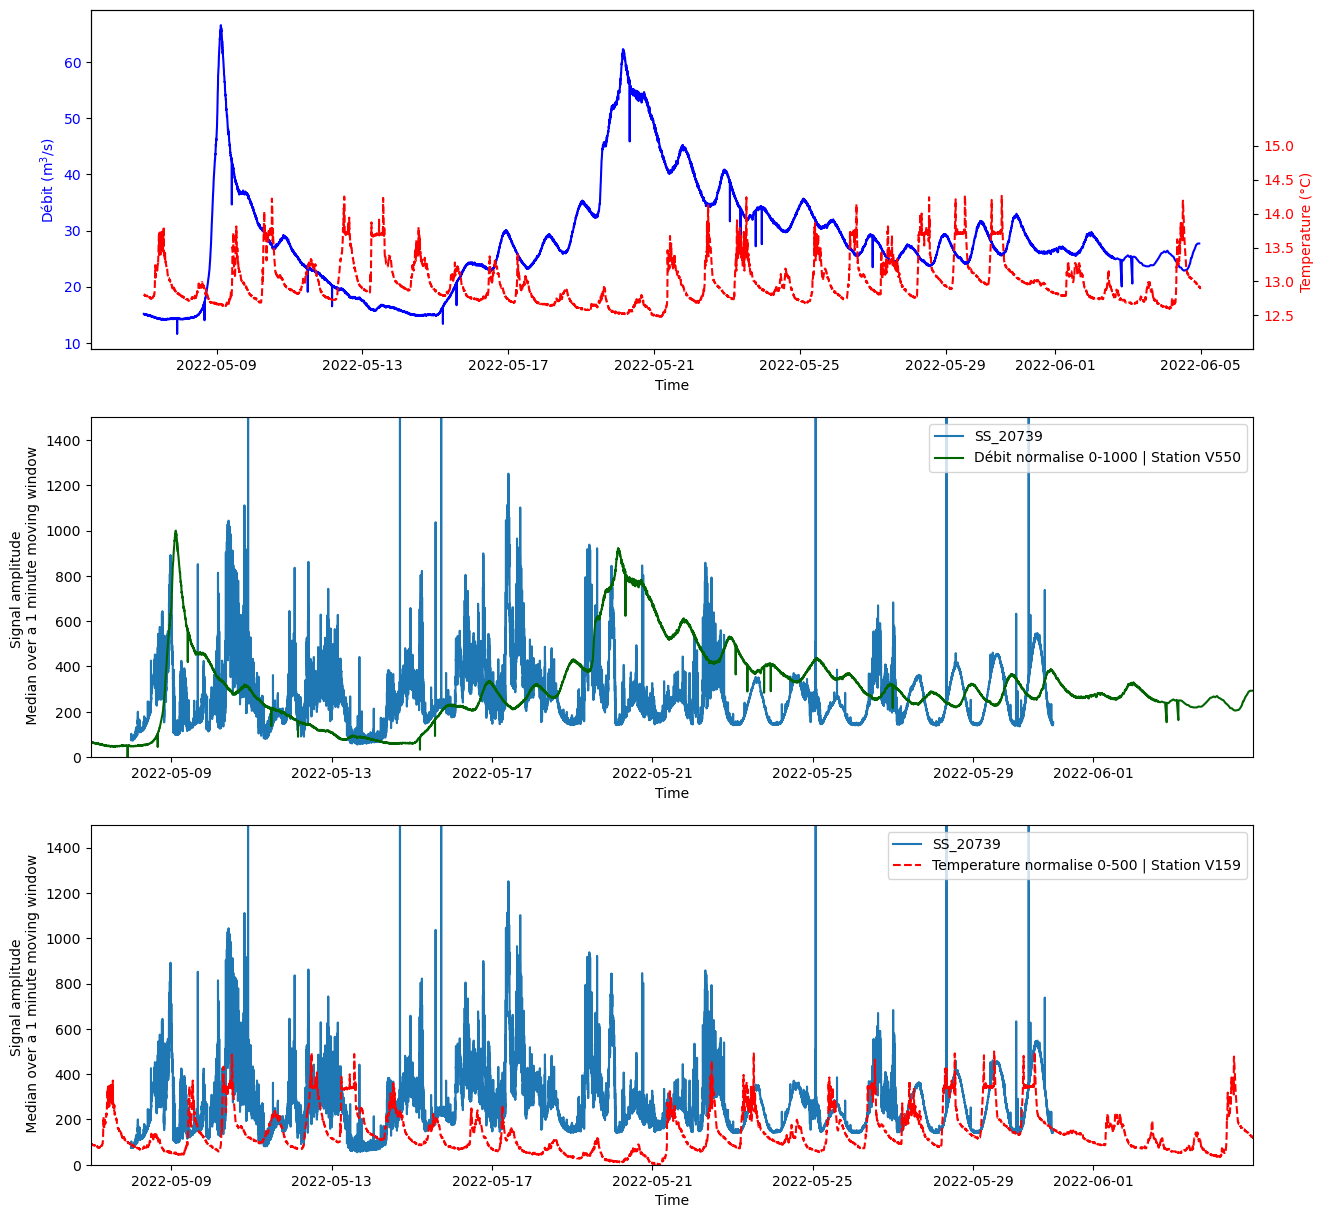

In [92]:
max_velos = np.amax(gauging_velos)
min_velos = np.amin(gauging_velos)
normalise_velos = (gauging_velos - min_velos)/(max_velos-min_velos)*1000

max_temp = np.amax(temp)
min_temp = np.amin(temp)
normalise_temp = (temp - min_temp)/(max_temp-min_temp)*500

fig = plt.subplots(3, 1, figsize=(15, 15))
ax1 = plt.subplot(3, 1, 1)


ax1.set_xlabel('Time') 
ax1.set_ylabel('Débit (m$^3$/s)', color = 'blue') 
ax1.plot(gauging_time, gauging_velos, label = 'Débit | Station V550', c='blue')
ax1.tick_params(axis ='y', labelcolor = 'blue') 
  
# Adding Twin Axes

ax2 = ax1.twinx() 
    
ax2.set_ylabel('Temperature (°C)'+24*' ', color = 'red')
ax2.set_ylim((12,17))
ax2.set_yticks([12.5,13,13.5,14,14.5,15])
ax2.plot(temp_time, temp, label = 'Température | Station V159', c='red', linestyle='--')
ax2.tick_params(axis ='y', labelcolor = 'red') 


plt.subplot(3, 1, 2)

#plt.plot(noise_time773,median773, label='SS_20773')
plt.xlim((temp_time[0],temp_time[len(temp_time)-1]))
plt.ylim((0,1500))
plt.plot(noise_time739,median739, label='SS_20739')
plt.plot(gauging_time,normalise_velos, label = 'Débit normalise 0-1000 | Station V550', c='darkgreen')
plt.xlabel('Time')
plt.ylabel('Signal amplitude \n Median over a 1 minute moving window')

plt.legend()

plt.subplot(3, 1, 3)

#plt.plot(noise_time773,median773, label='SS_20773')
plt.xlim((temp_time[0],temp_time[len(temp_time)-1]))
plt.ylim((0,1500))
plt.plot(noise_time739,median739, label='SS_20739')
plt.plot(temp_time,normalise_temp, label = 'Temperature normalise 0-500 | Station V159', c='red',linestyle='dashed')
plt.xlabel('Time')
plt.ylabel('Signal amplitude \n Median over a 1 minute moving window')

plt.legend()

plt.show()

